# Opening a restaraunt in Tallinn
### An IBM Data Science Specialization project
### By [Ilya Smelyanskiy](https://www.linkedin.com/in/ilya-smelyanskiy/)

## 1. The Task
A good friend of mine wants to open a restaurant in Tallinn. He is serious about his investment, so he wants to find the best spot for his restaurant. To do this, he wants several questions answered.

## 2. The Questions
* What is a good place to open a restaurant in the city?
    * Good place will have stable rate of visitors
    * Good place won't have too much competition
* What cuisine is served in high-reviewed restaurants?
* What kind of additional properties does this restaurant have?

## 3. The Data
OK, we have our task laid out. To do this, we need some data.
* We need statistical and census information about Tallinn
* We need information about restaurants in Tallinn

## 4. The Method to obtain the Data
We will obtain information about Tallinn. Thankfully, Estonia is a renowned leader in automation and open data, so anything we might need is located in a [register](https://avaandmed.tallinn.ee/eng/) created specifically for devs, like us.

Register is available for public use without limitations (thanks a lot!), and is provided in XML.
We have downloaded addresses by subdistricts in Tallinn from [here](https://www.tallinn.ee/eng/geoportal/Spatial-data)

There are some APIs to complete the goal of getting restaurant data, but they are all paid services. So instead we will parse everything ourselves! [www.vabalaud.ee](www.vabalaud.ee) contains some restaurants and data about them.

We will be augmenting this data with Forsquare API, to get additional matches, ratings and misc info, so our information is up to date. We will be matching data by addresses.

We will be using some geocoding, so Tallinn is located at **lat: 59.436962, lon: 24.753574**

## 5. Let's get to work! (Code)

In [188]:
# Importing some libraries that we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import json
import folium
import requests
from bs4 import BeautifulSoup as bs
import lxml
from statistics import mean

### Finding Restaraunts
There are a few APIs to find Restaraunts, but all of them want like 10$ for more than 10 requests. So instead we are going to parse Estonian website for the list of restaraunts in Tallinn. It has some useful information for each individual restaraunt and list of about 50 restaraunts in Tallinn.

In [189]:

# There are 4 pages of restaraunts, maximum 15 on the page. First let's collect links to detailed restaraunt pages
parse_url = "https://www.vabalaud.ee/en/restaurants?&s=City%3A+Tallinn&offset=" # On the end here should be offset
df_rest_pages = pd.DataFrame(columns=['Restaraunt', 'DetailsURL'])
for pageNum in range(0,4):
    html = requests.get("https://www.vabalaud.ee/en/restaurants?&s=City%3A+Tallinn&offset="+str(pageNum*15))
    soup = bs(html.content, 'lxml')
    frames = soup.find_all("div", class_="pakkumine")
    for frame in frames:
        a = frame.find("a", class_="noHover")
        name = a.text
        url = a['href'].split('?')[0]
        df_rest_pages = df_rest_pages.append({'Restaraunt':name, 'DetailsURL':url}, ignore_index=True)

display(df_rest_pages.head())

,Restaraunt,DetailsURL
0,Al Mare Grill,https://www.vabalaud.ee/en/restaurant/almaregr...
1,Allee,https://www.vabalaud.ee/en/restaurant/allee/
2,Argentiina (Lootsi 8),https://www.vabalaud.ee/en/restaurant/argentii...
3,Argentiina (Pärnu mnt. 37),https://www.vabalaud.ee/en/restaurant/argentiina/
4,Charlies Corner,https://www.vabalaud.ee/en/restaurant/charlies...


### Well done! We have some restaraunts, now we have to scrape all properties from each individual restaraunt
We'll just make a new dataframe with interesting properties from inside the page.

In [246]:
df_rest_full = pd.DataFrame(columns=['Restaraunt', 'DetailsURL', 'Address', 'Cuisine', 'Avg_Bill', 'Additional', 'Atmosphere', 'Food', 'Service', 'Latitude', 'Longitude'])

for row, _ in df_rest_pages.iterrows():
    # Original URL
    url = df_rest_pages['DetailsURL'][row]
    # Original Name
    name = df_rest_pages['Restaraunt'][row]
    
    # Prepare for parsing
    html = requests.get(url)
    soup = bs(html.content, 'lxml')
    
    # Adress
    addr = soup.find('div', class_="inf-box asukoht").p.text
    # Detect quisine (comma separated)
    cuis = soup.find('div', \
        class_="col-xs-7 col-sm-7 col-md-7 col-lg-7 titleInfo").a.text.split(":",1)[1].strip().lower()
    cuis = cuis.split(',')
    # One number - avg. bill in euro (to float)
    bill = mean(list(map(float, soup.find('div', class_ = "inf-box kMaksumus").p.text.split(" – "))))
    # Find values for ratings (to float)
    misc = soup.find_all('input', class_="rating")
    atmo = float(misc[0].get('value'))
    food = float(misc[1].get('value'))
    serv = float(misc[2].get('value'))

    # Latitude and Longitude are hidden in script.
    ## Extracting them by finding bordering substrings
    scripts = soup.find_all('script')
    scpt = str(scripts[3])

    left = 'center: ['
    right = '],'

    scpt = scpt[scpt.index(left)+len(left):scpt.index(right)]
    [lat, lng] = scpt.split(',')

    # Additional info
    ## Just form a comma separated string of various services at venue
    addt = soup.find('div', class_='lisaInfo').p.find_all('a')
    addt_arr = []
    for a in addt:
        addt_arr.append(a.text.lower())
    addt = ",".join(addt_arr)
    addt = addt.split(",")

    df_rest_full = df_rest_full.append({'Restaraunt':name, \
                                        'DetailsURL':url, \
                                        'Address':addr, \
                                        'Cuisine':cuis, \
                                        'Avg_Bill':bill,\
                                        'Atmosphere':atmo,\
                                        'Food':food,\
                                        'Service':serv,\
                                        'Latitude': float(lat),\
                                        'Longitude': float(lng),\
                                        'Additional':addt\
                                        }, ignore_index=True)

display(df_rest_full.head())

,Restaraunt,DetailsURL,Address,Cuisine,Avg_Bill,Additional,Atmosphere,Food,Service,Latitude,Longitude
0,Al Mare Grill,https://www.vabalaud.ee/en/restaurant/almaregr...,"Mõisa tn 4 / Vabaõhumuuseumi tee 3, Tallinn, H...","[grill, european, american]",9.0,"[wifi, internet, accessible toilet, wheelch...",4.4,4.5,4.5,59.427152,24.655658
1,Allee,https://www.vabalaud.ee/en/restaurant/allee/,"Kanuti 2, Tallinn, Harju County, 10111",[international],12.0,"[wifi, internet, accessible toilet, wheelch...",4.6,4.1,4.3,59.440128,24.751131
2,Argentiina (Lootsi 8),https://www.vabalaud.ee/en/restaurant/argentii...,"Lootsi 8, Tallinn, Harju County, 10151",[argentinean],12.0,"[wifi, internet, smoking room or cigar loung...",4.4,4.5,4.1,59.440838,24.765225
3,Argentiina (Pärnu mnt. 37),https://www.vabalaud.ee/en/restaurant/argentiina/,"Pärnu mnt 37, Tallinn, Harju County, 10119",[argentinean],18.0,"[wifi, internet, smoking room or cigar loung...",4.5,4.7,4.6,59.429272,24.743789
4,Charlies Corner,https://www.vabalaud.ee/en/restaurant/charlies...,"Juhkentali 28, Tallinn, Harju County, 10132",[international],12.0,"[wifi, internet, accessible toilet, private...",0.0,0.0,0.0,59.427606,24.764699


In [247]:
df_rest_full.to_csv('restaraunts_tallin.csv', index = False)

### Phew! Data is collected!
It is now safe and sound in a .csv file, with some properties for each entry.
### Dataset:
|Column name|Description|
| --- | --- |
|**Restaraunt**| Restaraunt name is displayed here|
|**DetailsURL**| This is url from which data is acquired|
|**Address**| Address of the Restaraunt|
|**Cuisine**| Comma separated types of quisine|
|**Avg_Bill**| Average bill (float), estimated|
|**Additional**| List of properties that the venue has (comma separated)|
|**Atmosphere**| Atmosphere rating (1-5), float|
|**Food**| Food rating (1-5), float |
|**Service**| Service rating (1-5), float |
|**Latitude**| Latitude of venue |
|**Longitude**| Longitude of venue |

### Put them all on the map!
The restaraunts are ready to be placed on the map!


<Figure size 432x288 with 0 Axes>

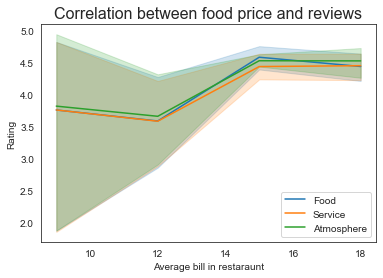

In [248]:
fig = plt.figure()
sns.set_style(style="white")
f, ax = plt.subplots(1, 1)
sns.lineplot(data=df_rest_full, x='Avg_Bill', y='Food', markers = "o")
sns.lineplot(data=df_rest_full, x='Avg_Bill', y='Service', markers = "x")
sns.lineplot(data=df_rest_full, x='Avg_Bill', y='Atmosphere', markers = ">")
plt.xlabel("Average bill in restaraunt")
plt.ylabel("Rating")
plt.title("Correlation between food price and reviews", size = 16)
plt.legend(['Food','Service','Atmosphere'], loc='lower right')
plt.show()

### Interesting first observations:
* Expensive resaraunts only get high ratings
* Cheaper resaraunts have more spread
* Food is rated highest in medium-to-expensive resaraunts
* The most expensive resaraunts have better atmosphere
* Overall, people don't tend to rate resaraunts less than 3.8 stars (or such resaraunts close fast)

Anyway, grades are so closely related that we can implement one metic - "Score", that is average pf those 3 Scores.


In [249]:
#adding avg score
df_rest_full['Score'] = np.nan

for row, _ in df_rest_pages.iterrows():
    scores = [df_rest_full['Food'][row],df_rest_full['Service'][row],df_rest_full['Atmosphere'][row]]
    df_rest_full['Score'][row] = mean(scores)

display(df_rest_full.head())

,Restaraunt,DetailsURL,Address,Cuisine,Avg_Bill,Additional,Atmosphere,Food,Service,Latitude,Longitude,Score
0,Al Mare Grill,https://www.vabalaud.ee/en/restaurant/almaregr...,"Mõisa tn 4 / Vabaõhumuuseumi tee 3, Tallinn, H...","[grill, european, american]",9.0,"[wifi, internet, accessible toilet, wheelch...",4.4,4.5,4.5,59.427152,24.655658,4.466667
1,Allee,https://www.vabalaud.ee/en/restaurant/allee/,"Kanuti 2, Tallinn, Harju County, 10111",[international],12.0,"[wifi, internet, accessible toilet, wheelch...",4.6,4.1,4.3,59.440128,24.751131,4.333333
2,Argentiina (Lootsi 8),https://www.vabalaud.ee/en/restaurant/argentii...,"Lootsi 8, Tallinn, Harju County, 10151",[argentinean],12.0,"[wifi, internet, smoking room or cigar loung...",4.4,4.5,4.1,59.440838,24.765225,4.333333
3,Argentiina (Pärnu mnt. 37),https://www.vabalaud.ee/en/restaurant/argentiina/,"Pärnu mnt 37, Tallinn, Harju County, 10119",[argentinean],18.0,"[wifi, internet, smoking room or cigar loung...",4.5,4.7,4.6,59.429272,24.743789,4.600000
4,Charlies Corner,https://www.vabalaud.ee/en/restaurant/charlies...,"Juhkentali 28, Tallinn, Harju County, 10132",[international],12.0,"[wifi, internet, accessible toilet, private...",0.0,0.0,0.0,59.427606,24.764699,0.000000


## Augmenting with Foursquare API
We will be using foursquare API to enchance our data. We will be using address to connect data.
Unfortunately Foursquare information is very limited on Estonia, but we will use it as an excercise nontheless.

In [250]:
API_SECRET = ''
API_CLIENT = ''
with open('Z_API_SECRET', 'r') as f:
    API_CLIENT = f.readline().strip()
    API_SECRET = f.readline().strip()

def Check_Venue(lat, lng, radius = 100):
    VERSION = '20180604'
    LIMIT = 1
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        API_CLIENT, 
        API_SECRET, 
        VERSION, 
        lat,
        lng, 
        radius, 
        LIMIT)

    try:
        results = requests.get(url).json()
    except:
        results = 0

    return results

In [251]:
results = Check_Venue(df_rest_full['Latitude'][0], df_rest_full['Longitude'][0])

In [252]:
nearby_venues = pd.DataFrame()
for row, _ in df_rest_pages.iterrows():
    results = Check_Venue(df_rest_full['Latitude'][row], df_rest_full['Longitude'][row])
    venues = results['response']['groups'][0]['items']
    nearby_venues = nearby_venues.append(pd.io.json.json_normalize(venues))

display(nearby_venues.head())

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,...,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.neighborhood,venue.venuePage.id
0,e-0-4bf24fd225afb713c1294b6f-0,0,"[{'summary': 'This spot is popular', 'type': '...",4bf24fd225afb713c1294b6f,Al Mare Grill,Mõisa tn. 4,Vabaõhumuuseumi tee,59.427086,24.655628,"[{'label': 'display', 'lat': 59.42708630233438...",...,EE,Tallinn,Harju maakond,Eesti,"[Mõisa tn. 4 (Vabaõhumuuseumi tee), 13522 Tall...","[{'id': '4bf58dd8d48988d1df931735', 'name': 'B...",0,[],NaN,NaN
0,e-0-4d81edb76476a09330db1753-0,0,"[{'summary': 'This spot is popular', 'type': '...",4d81edb76476a09330db1753,Reval Sport,Aia 20,NaN,59.440700,24.751576,"[{'label': 'display', 'lat': 59.44070047431795...",...,EE,Tallinn,Harju maakond,Eesti,"[Aia 20, Tallinn, Eesti]","[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",0,[],Vanalinn,NaN
0,e-0-556b79c2498e90a4ea486d0c-0,0,"[{'summary': 'This spot is popular', 'type': '...",556b79c2498e90a4ea486d0c,Escape Room,Lootsi 8,Ahtri,59.441070,24.765555,"[{'label': 'display', 'lat': 59.4410700604993,...",...,EE,Tallinn,Harju maakond,Eesti,"[Lootsi 8 (Ahtri), 10151 Tallinn, Eesti]","[{'id': '5f2c2834b6d05514c704451e', 'name': 'E...",0,[],NaN,NaN
0,e-0-5a8172341fa7634a4cda427b-0,0,"[{'summary': 'This spot is popular', 'type': '...",5a8172341fa7634a4cda427b,Poke Bowl,13 Hariduse,NaN,59.429523,24.743278,"[{'label': 'display', 'lat': 59.429523, 'lng':...",...,EE,Tallinn,Harju maakond,Eesti,"[13 Hariduse, 10119 Tallinn, Eesti]","[{'id': '52e81612bcbc57f1066b79fe', 'name': 'H...",0,[],NaN,NaN
0,e-0-4b968814f964a52090d234e3-0,0,"[{'summary': 'This spot is popular', 'type': '...",4b968814f964a52090d234e3,Tchaikovsky,Vene 9,NaN,59.437738,24.747058,"[{'label': 'display', 'lat': 59.43773828726152...",...,EE,Tallinn,Harju maakond,Eesti,"[Vene 9, 10123 Tallinn, Eesti]","[{'id': '4bf58dd8d48988d109941735', 'name': 'E...",0,[],NaN,NaN


In [253]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = ['Restaraunt', 'Additional', 'Latitude', 'Longitude']
nearby_venues=nearby_venues.drop(columns=['Latitude', 'Longitude'])
nearby_venues.head()

,Restaraunt,Additional
0,Al Mare Grill,BBQ Joint
0,Reval Sport,Gym / Fitness Center
0,Escape Room,Escape Room
0,Poke Bowl,Hawaiian Restaurant
0,Tchaikovsky,Eastern European Restaurant


In [254]:
result = pd.merge(df_rest_full, nearby_venues, on='Restaraunt', how='left')

In [255]:
display(result.head())

,Restaraunt,DetailsURL,Address,Cuisine,Avg_Bill,Additional_x,Atmosphere,Food,Service,Latitude,Longitude,Score,Additional_y
0,Al Mare Grill,https://www.vabalaud.ee/en/restaurant/almaregr...,"Mõisa tn 4 / Vabaõhumuuseumi tee 3, Tallinn, H...","[grill, european, american]",9.0,"[wifi, internet, accessible toilet, wheelch...",4.4,4.5,4.5,59.427152,24.655658,4.466667,BBQ Joint
1,Allee,https://www.vabalaud.ee/en/restaurant/allee/,"Kanuti 2, Tallinn, Harju County, 10111",[international],12.0,"[wifi, internet, accessible toilet, wheelch...",4.6,4.1,4.3,59.440128,24.751131,4.333333,NaN
2,Argentiina (Lootsi 8),https://www.vabalaud.ee/en/restaurant/argentii...,"Lootsi 8, Tallinn, Harju County, 10151",[argentinean],12.0,"[wifi, internet, smoking room or cigar loung...",4.4,4.5,4.1,59.440838,24.765225,4.333333,NaN
3,Argentiina (Pärnu mnt. 37),https://www.vabalaud.ee/en/restaurant/argentiina/,"Pärnu mnt 37, Tallinn, Harju County, 10119",[argentinean],18.0,"[wifi, internet, smoking room or cigar loung...",4.5,4.7,4.6,59.429272,24.743789,4.600000,NaN
4,Charlies Corner,https://www.vabalaud.ee/en/restaurant/charlies...,"Juhkentali 28, Tallinn, Harju County, 10132",[international],12.0,"[wifi, internet, accessible toilet, private...",0.0,0.0,0.0,59.427606,24.764699,0.000000,NaN


# Question 1. What is a good place for a restaraunt?
### Time to place them on the map!
We have roughly 50 venues. Let's see them on the map.
I expect them to be mostly located in historic center of the town.

In [256]:
latitude = 59.436962
longitude = 24.753574

map_tallinn = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, restaraunt in zip(result['Latitude'], result['Longitude'], result['Restaraunt']):
    label = '{}'.format(restaraunt)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tallinn)  
    
map_tallinn



#### GitHub sometimes decides not to show the map, so here it is as a screenshot:
![Map of Tallinn restaraunts](tm.jpg)

Without any testing it is visible that majority of restaraunts are located in the center of the town.

However there are groups way outside.

## For better representation, let's cluster them using K-Means


In [257]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

clustering = result.iloc[:,[-4, -3]]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters).fit(clustering)

# add cluster labels to dataframe:
clustering.insert(0, 'Labels', kmeans.labels_)

display(clustering.head())

,Labels,Latitude,Longitude
0,2,59.427152,24.655658
1,3,59.440128,24.751131
2,0,59.440838,24.765225
3,3,59.429272,24.743789
4,0,59.427606,24.764699


In [258]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = matplotlib.cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(clustering['Latitude'], clustering['Longitude'], clustering['Labels']):
    label = folium.Popup(str(str(lat)+" "+str(lon) + '\nCluster ' + str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### GitHub sometimes decides not to show the map, so here it is as a screenshot:
![Map of Tallinn restaurants](tmc.jpg)

The clustering we see makes a lot of sense. It highlights main groups of venues by coordinates.
* RED - this is historic town square of Tallinn inside city castle walls. It has a lot of tourists all year round and seems like a good place for a restaurant, but it has a lot of competition.
* ORANGE - this is a modern buisness-district of the city with several skyscrapers and 5-star hotels located in the area. These restaurants are more fairly spread, while still have a lot of tourists and office workers coming through
* BLUE - this is Pirreta. It is located at the seaside, near a major yacht club. These restaurants are probably more expensive and flow of visitors is significantly lower here.
* PURPLE - this is Mustamae, a calm neighbourhood. Fast-food chains and delivery services here are more important than restaurants.
* GREEN - This is an outlier, a restaraunt located in the less visited side of town. It is relatively new and has little competition

## Let's look into placmenent density

In [259]:
from folium import plugins

heatmap_map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='OpenStreetMap')

for _, row in result.iterrows():
    data = result.iloc[:,[-4, -3]]
    hm = plugins.HeatMap(data, max_opacity=0.5)
    heatmap_map.add_children(hm)


heatmap_map

#### GitHub sometimes decides not to show the map, so here it is as a screenshot:
![Map of Tallinn restaurants](tmh.jpg)

As we can see, the old city and buisness district have the highest density of restaurants in the area

# Question 2. What quisine is served in highest-ranked restaraunts?

In [332]:
from sklearn import metrics
 
def Evaluationmatrix(y_true, y_predict):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_true,y_predict)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_true,y_predict)))

def Evaluationmatrix_dict(y_true, y_predict, name = 'Linear'):
    dict_matrix = {}
    dict_matrix['Series Name'] = name
    dict_matrix['Mean Squared Error'] = metrics.mean_squared_error(y_true,y_predict)
    dict_matrix['Mean Absolute Error'] = metrics.mean_absolute_error(y_true,y_predict)
    return dict_matrix

In [333]:
#Let's make dummies for food types and clean everything up
Cuisine = pd.get_dummies(pd.DataFrame(result['Cuisine'].tolist()).stack()).sum(level=0)
# Some of the columns are the same thing
Cuisine['american'] = Cuisine[' american'] | Cuisine['american']
Cuisine['estonian'] = Cuisine[' estonian'] | Cuisine['estonian'] | Cuisine['dedicated to estonian produce']
Cuisine['european'] = Cuisine[' european'] | Cuisine['european']
Cuisine['indian'] = Cuisine[' indian'] | Cuisine['indian']
Cuisine['international'] = Cuisine['world'] | Cuisine['international']
# Remove extra columns
Cuisine = Cuisine.drop(columns=[' american', ' estonian', 'dedicated to estonian produce', ' european', ' indian', 'world'])
Cuisine['Score'] = result['Score']
display(Cuisine.head())

,scandinavian,sichuan,american,argentinean,chinese,estonian,european,french,fusion,greek,...,international,italian,japanese,medieval,mediterranean,nordic,russian,steak house,thai,Score
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.466667
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,4.333333
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.333333
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.600000
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0.000000


In [334]:
list(Cuisine.columns.values)

[' scandinavian',
 ' sichuan',
 'american',
 'argentinean',
 'chinese',
 'estonian',
 'european',
 'french',
 'fusion',
 'greek',
 'grill',
 'hawaii',
 'indian',
 'international',
 'italian',
 'japanese',
 'medieval',
 'mediterranean',
 'nordic',
 'russian',
 'steak house',
 'thai',
 'Score']

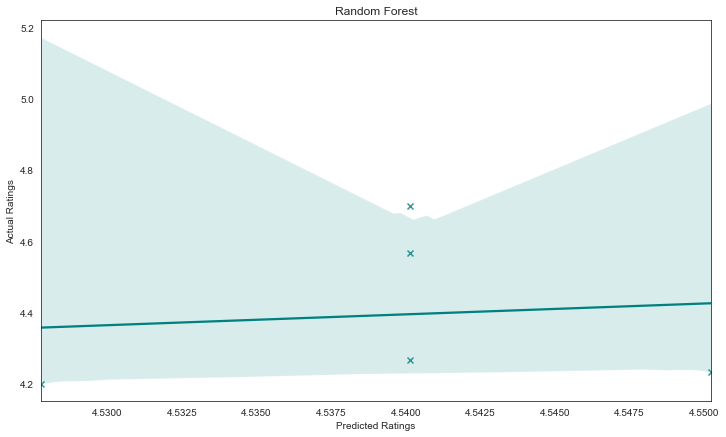

In [352]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = Cuisine.drop(columns=['Score'])
y = Cuisine['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

model = RandomForestRegressor()
model.fit(X_train,y_train)
Results = model.predict(X_test)

#evaluation
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results, name = 'RFR for Cuisine'),ignore_index = True)

plt.figure(figsize=(12,7))
sns.regplot(Results ,y_test, color='teal', marker = 'x')
plt.title('Random Forest')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

,Pct
chinese,0.000000
international,0.000024
japanese,0.006919
mediterranean,0.008654
scandinavian,0.009726
argentinean,0.011053
steak house,0.011319
grill,0.017203
sichuan,0.017276
european,0.017582


<Figure size 1008x720 with 0 Axes>

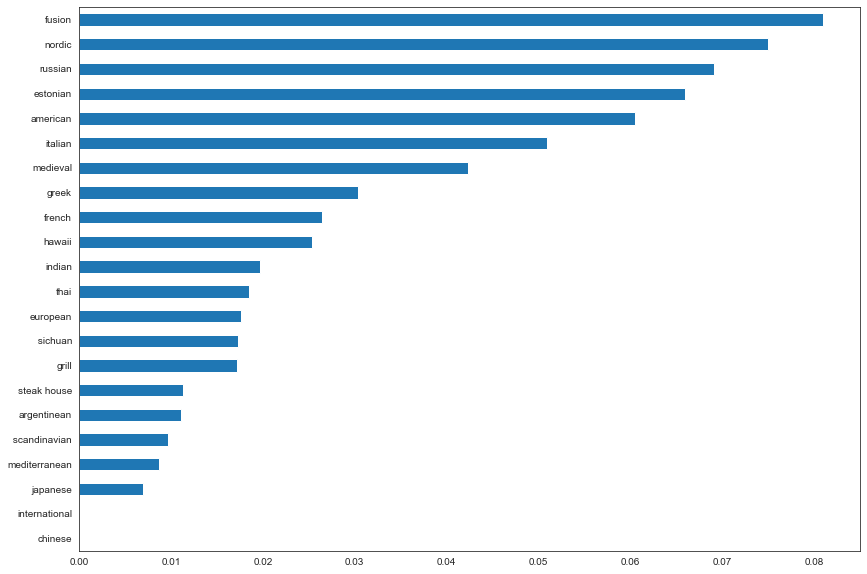

In [353]:
Feat_impt = {}
for col,feat in zip(X.columns,model3.feature_importances_):
    Feat_impt[col] = feat

Feat_impt_df = pd.DataFrame.from_dict(Feat_impt,orient = 'index')
Feat_impt_df.sort_values(by = 0, inplace = True)
Feat_impt_df.rename(index = str, columns = {0:'Pct'},inplace = True)

display(Feat_impt_df)

plt.figure(figsize= (14,10))
Feat_impt_df.plot(kind = 'barh',figsize= (14,10),legend = False)
plt.show()

# Q3. What are the properties of a good venue?
### Which qualities are present in restaurants with high overall score?
Every venue has a list of properties So firstly, we need to prepare data a bit more.

In [336]:
properties = pd.get_dummies(pd.DataFrame(result['Additional_x'].tolist()).stack()).sum(level=0)
# Some of the columns are the same thing, like "child friendly attitde" and "child friendly"
properties['child friendly'] = properties[' child friendly'] | properties[' child friendly attitude']
properties['accessible toilet'] = properties[' accessible toilet'] | properties['accessible toilet']
properties['wheelchair access'] = properties[' wheelchair access'] | properties['wheelchair access']
properties['catering'] = properties['catering'] | properties[' catering']
# Remove extra columns
properties= properties.drop(columns=[' child friendly attitude', ' child friendly', ' accessible toilet', ' wheelchair access', ' catering'])
# Add final metric:
properties['Score'] = result['Score']
display(properties.head())

,accommodation,breakfast,business meetings,conference room,courses,daily special,family days,fireplace,food courses,gift card,...,tv for presentations or entertainment,wine education classes,accessible toilet,catering,private room or private hall,summer terrace,wheelchair access,wifi,child friendly,Score
0,0,0,1,0,0,1,0,0,0,1,...,0,0,1,1,0,0,1,1,0,4.466667
1,1,1,1,1,0,1,0,1,0,1,...,0,0,1,0,0,0,1,1,1,4.333333
2,0,0,1,1,0,1,1,0,1,1,...,0,0,0,0,0,0,1,1,1,4.333333
3,0,0,1,1,0,1,1,0,0,1,...,0,0,0,1,0,0,0,1,0,4.600000
4,1,1,1,1,0,1,0,0,0,1,...,0,0,1,0,0,0,1,1,1,0.000000


In [337]:
list(properties.columns.values)

[' accommodation',
 ' breakfast',
 ' business meetings',
 ' conference room',
 ' courses',
 ' daily special',
 ' family days',
 ' fireplace',
 ' food courses',
 ' gift card',
 ' internet',
 ' live music',
 ' loyalty card',
 ' open kitchen',
 ' pet friendly',
 ' private dining room',
 ' private room or private hall',
 ' projector',
 ' sauna party',
 ' sea view',
 ' smoking room or cigar lounge',
 ' summer terrace',
 ' terrace',
 ' top 50 restaurant',
 ' tv for presentations or entertainment',
 ' wine education classes',
 'accessible toilet',
 'catering',
 'private room or private hall',
 'summer terrace',
 'wheelchair access',
 'wifi',
 'child friendly',
 'Score']

### Let's start with linear regression

In [338]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split

X = properties.drop(columns=['Score'])
y = properties['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [339]:
model = LinearRegression()
model.fit(X_train,y_train)
Results = model.predict(X_test)

In [340]:
# Creation of results dataframe and addition of first entry
resultsdf = pd.DataFrame()
resultsdf = resultsdf.from_dict(Evaluationmatrix_dict(y_test, Results), orient = 'index')
resultsdf = resultsdf.transpose()

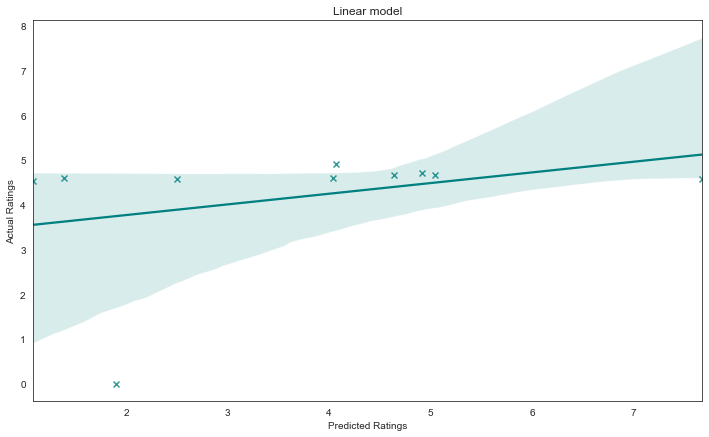

In [341]:
plt.figure(figsize=(12,7))
sns.regplot(Results, y_test, color='teal', marker = 'x')
plt.title('Linear model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()



Unfortunately, it looks like linear regression doesn't predict ratings very well

In [342]:

print ('Actual mean of population : ' + str(y.mean()))
print ('Mean : ' + str(Results.mean()))
print ('Std : ' + str(Results.std()))

Actual mean of population : 3.9646666666666657
Mean : 3.7236846863703503
Std : 1.928190695587135


### Next up - SVM for prediction

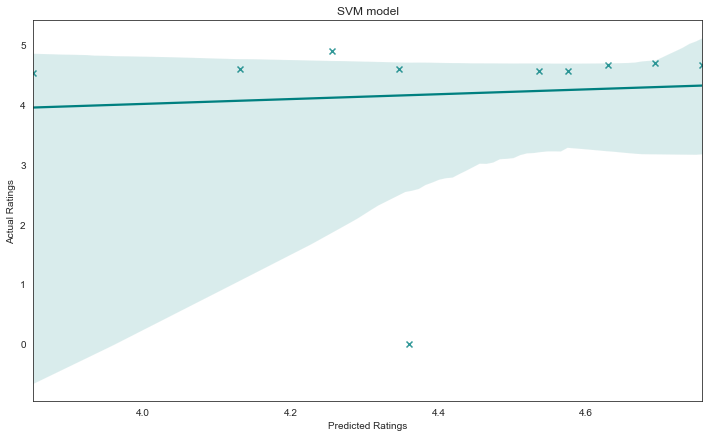

In [343]:
from sklearn import svm
#Integer encoding

model2 = svm.SVR()
model2.fit(X_train,y_train)

Results2 = model2.predict(X_test)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test, Results2, name = 'SVM'),ignore_index = True)

plt.figure(figsize=(12,7))
sns.regplot(Results2,y_test,color='teal', marker = 'x')
plt.title('SVM model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [344]:

print ('Mean : ' + str(Results2.mean()))
print ('Std : ' + str(Results2.std()))

Mean : 4.413505082999157
Std : 0.26671588858771095


SVM did a bit better, predicting values more accurately

### Maybe Random Forest will do better

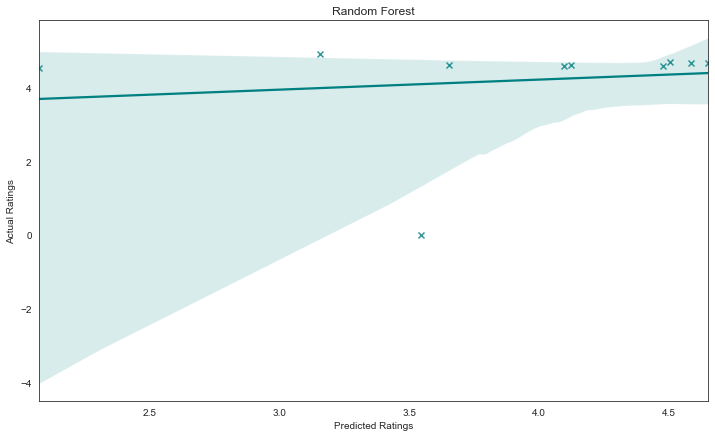

In [345]:
from sklearn.ensemble import RandomForestRegressor

model3 = RandomForestRegressor()
model3.fit(X_train,y_train)
Results3 = model3.predict(X_test)

#evaluation
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results3, name = 'RFR'),ignore_index = True)

plt.figure(figsize=(12,7))
sns.regplot(Results3,y_test, color='teal', marker = 'x')
plt.title('Random Forest')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [346]:
print ('Integer encoding(mean) : ' + str(Results3.mean()))
print ('Integer encoding(std) : ' + str(Results3.std()))


Integer encoding(mean) : 3.8861999999999997
Integer encoding(std) : 0.7688046883889881


## Using RF Model, let's look at the feature importance:
Features weight is displayed relative to their importance in high rating

,Pct
courses,0.000000
private room or private hall,0.000000
open kitchen,0.000024
wine education classes,0.000513
tv for presentations or entertainment,0.002745
summer terrace,0.004987
private dining room,0.006919
projector,0.008654
accommodation,0.009726
conference room,0.011053


<Figure size 1008x720 with 0 Axes>

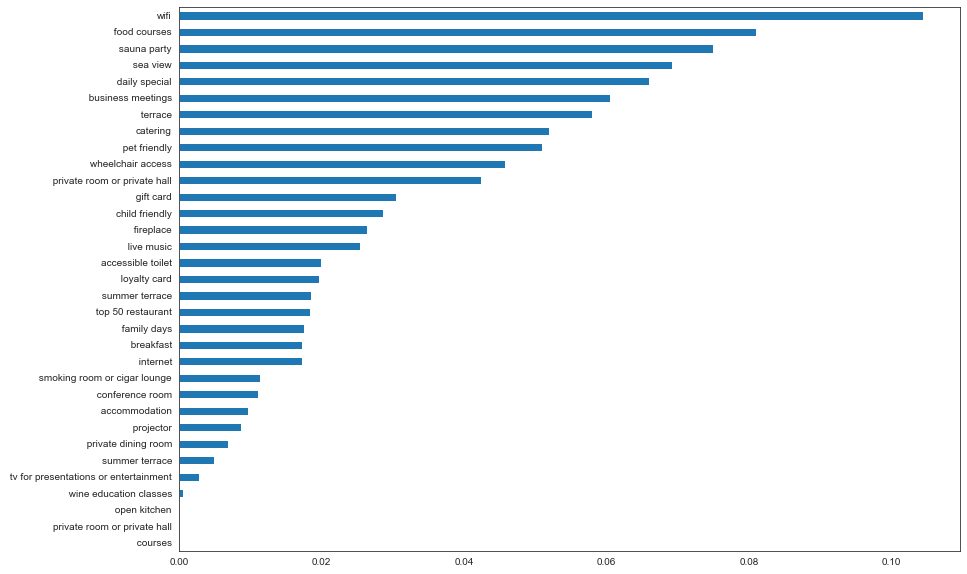

In [347]:
Feat_impt = {}
for col,feat in zip(X.columns,model3.feature_importances_):
    Feat_impt[col] = feat

Feat_impt_df = pd.DataFrame.from_dict(Feat_impt,orient = 'index')
Feat_impt_df.sort_values(by = 0, inplace = True)
Feat_impt_df.rename(index = str, columns = {0:'Pct'},inplace = True)

display(Feat_impt_df)

plt.figure(figsize= (14,10))
Feat_impt_df.plot(kind = 'barh',figsize= (14,10),legend = False)
plt.show()

# Now we can answer the questions given in the very beginning!
## Q1. Where is a good location?

A1.1: A good location in highly competitive zone is city center, as most venues are located there due to highest tourist throughput

A1.2: A good location in uncompetitive area is entire neighbourhood of Kristiine, which doesn't have any competition

A1.3: A good location in moderately competitive area is in city buisness center, where there is still higher traffic of tourists and office workers, but less competition

## Q2. What kind of quisine is served in higher ranking restaraunts

## Q3. What features does a high-rated restaraunt have?
A3.1: Expensive Restauraunts have higher rating overall.

A3.2: A list of features in relation to their impact on the score is provided above

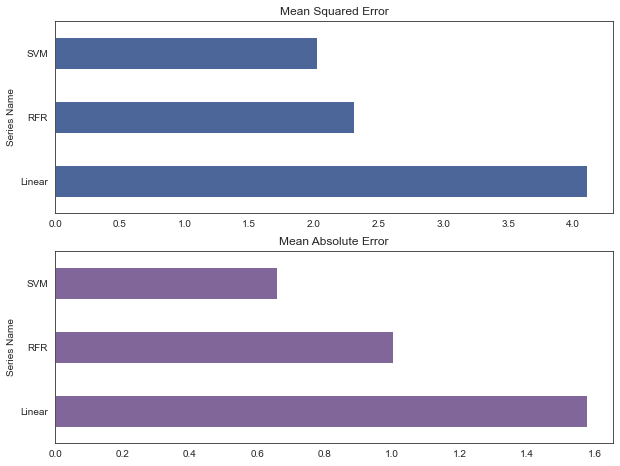

In [348]:
## Bonus: Error analysis
resultsdf.set_index('Series Name', inplace = True)

plt.figure(figsize = (10,12))
plt.subplot(3,1,1)
resultsdf['Mean Squared Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.3, 0.4, 0.6, 1), title = 'Mean Squared Error')
plt.subplot(3,1,2)
resultsdf['Mean Absolute Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.5, 0.4, 0.6, 1), title = 'Mean Absolute Error')
plt.show()